# Model

In [20]:
# models/dibs.py
import torch
from torch.distributions import Normal
import numpy as np
import logging
from typing import Dict, Any, Tuple


log = logging.getLogger(__name__)


def acyclic_constr(g: torch.Tensor, d: int) -> torch.Tensor:
    """H(G) from NOTEARS (Zheng et al.) with a series fallback for large *d*."""
    alpha = 1.0 / d
    eye = torch.eye(d, device=g.device, dtype=g.dtype)
    m = eye + alpha * g

    if d <= 10:
        return torch.trace(torch.linalg.matrix_power(m, d)) - d

    try:
        eigvals = torch.linalg.eigvals(m)
        return torch.sum(torch.real(eigvals ** d)) - d
    except RuntimeError:
        trace, p = torch.tensor(0.0, device=g.device, dtype=g.dtype), g.clone()
        for k in range(1, min(d + 1, 20)):
            trace += (alpha ** k) * torch.trace(p) / k
            if k < 19:
                p = p @ g
        return trace


def log_gaussian_likelihood(x: torch.Tensor, pred_mean: torch.Tensor, sigma: float = 0.1) -> torch.Tensor:
    sigma_tensor = torch.tensor(sigma, dtype=pred_mean.dtype, device=pred_mean.device)
    
    residuals = x - pred_mean
    #old incorrect log_prob = -0.5 * (np.log(2 * np.pi) -  (1/2)* torch.log(sigma_tensor**2) -  0.5*(residuals / sigma_tensor) ** 2) old
    log_prob = -0.5 * (torch.log(2 * torch.pi * sigma_tensor**2)) - 0.5 * ((residuals / sigma_tensor)**2)
    #normal_dist = Normal(loc=pred_mean, scale=sigma_tensor)
    #log_prob = normal_dist.log_prob(x)

    return torch.sum(log_prob)

def scores(z: torch.Tensor, alpha: float) -> torch.Tensor:
    u, v = z[..., 0], z[..., 1]
    raw_scores = alpha * torch.einsum('...ik,...jk->...ij', u, v)
    *batch_dims, d, _ = z.shape[:-1]
    diag_mask = 1.0 - torch.eye(d, device=z.device, dtype=z.dtype)
    if batch_dims:
        diag_mask = diag_mask.expand(*batch_dims, d, d)
    return raw_scores * diag_mask

def bernoulli_soft_gmat(z: torch.Tensor, hparams: Dict[str, Any]) -> torch.Tensor:
    probs = torch.sigmoid(scores(z, hparams["alpha"]))
    d = probs.shape[-1]
    diag_mask = 1.0 - torch.eye(d, device=probs.device, dtype=probs.dtype)
    if probs.ndim == 3:
        diag_mask = diag_mask.expand(probs.shape[0], d, d)
    return probs * diag_mask

def gumbel_soft_gmat(z: torch.Tensor,
                     hparams: Dict[str, Any]) -> torch.Tensor:
    """
    Soft Gumbel–Softmax adjacency  (Eq. B.6)

        g_ij  = σ_τ( L_ij + α⟨u_i , v_j⟩ )

    where  L_ij ~ Logistic(0,1)  and  τ = hparams['tau']. appendix b2
    """
    raw = scores(z, hparams["alpha"])

    # Logistic(0,1) noise   L = log U - log(1-U)
    u = torch.rand_like(raw)
    L = torch.log(u) - torch.log1p(-u)

    logits = (raw + L) / hparams["tau"]
    g_soft = torch.sigmoid(logits)

    d = g_soft.size(-1)
    mask = 1.0 - torch.eye(d, device=z.device, dtype=z.dtype)
    return g_soft * mask

def log_full_likelihood(data: Dict[str, Any], soft_gmat: torch.Tensor, theta: torch.Tensor, hparams: Dict[str, Any]) -> torch.Tensor:
    ## TODO: Expert belief: update this to use interventions, change the full likelihood 
    # and also add log bernoulli likelihood calculatior
    x_data = data['x']
    effective_W = theta * soft_gmat
    pred_mean = torch.matmul(x_data, effective_W)
    sigma_obs = hparams.get('sigma_obs_noise', 0.1)
    return log_gaussian_likelihood(x_data, pred_mean, sigma=sigma_obs)

def log_theta_prior(theta_effective: torch.Tensor, sigma: float) -> torch.Tensor:
    return log_gaussian_likelihood(theta_effective, torch.zeros_like(theta_effective), sigma=sigma)

def gumbel_acyclic_constr_mc(z: torch.Tensor, d: int, hparams: Dict[str, Any]) -> torch.Tensor:
    h_samples = []
    for _ in range(hparams['n_nongrad_mc_samples']):
        # FOR NOW, JUST GIVE THE SOFT MATRIX, AND BY ANNEALING IT TO HARD MATRIX
        g_soft = gumbel_soft_gmat(z, hparams)
        h_samples.append(acyclic_constr(g_soft, d))
        
        # should gumbel soft gmat to hard gmat be done with >0.5 or with a sigmoid?  
        #print(f'g_soft shape: {g_soft.shape}, values: \n {g_soft}')
        #if hparams['current_iteration'] % 1 == 0:
        #    print(f'g_soft shape: {g_soft.shape}, values: \n {g_soft}')
        #g_hard = torch.bernoulli(g_soft)
        #if hparams['current_iteration'] % 1 == 0:
        #    print(f'g_hard shape: {g_hard.shape}, values: \n {g_hard}')
        #print(f'g_hard shape: {g_hard.shape}, values: \n {g_hard}')
        #h_samples.append(acyclic_constr(g_hard, d))
        #g_hard = (g_soft > 0.5).float()
        #how about this  mentioned in dibs       g_ST   = g_hard + (g_soft - g_soft.detach())   # straight-through
        
        #TODO fix above
        # for now use g_soft
        
    h_samples = torch.stack(h_samples)


    return torch.mean(h_samples, dim=0)

def grad_z_log_joint_gumbel(z: torch.Tensor, theta: torch.Tensor, data: Dict[str, Any], hparams: Dict[str, Any]) -> torch.Tensor:
    d = z.shape[0]
    theta_const = theta
    
    #z.requires_grad_(True)
    # --- Part 1: Prior Gradient ---
    # MC estimate of gradient of acyclicity constraint using Gumbel soft graphs

    h_mean = gumbel_acyclic_constr_mc(z, d, hparams)
    grad_h_mc = torch.autograd.grad(h_mean, z)[0]
    grad_log_z_prior_total = -hparams['beta'] * grad_h_mc - (z / hparams['sigma_z']**2)

    # --- Part 2: Likelihood Gradient ---
    
    # 1. We need to collect the log-probability AND the gradient for each sample.
    log_density_samples = []
    grad_samples = []

    for _ in range( hparams['n_grad_mc_samples']):
        # 2. Generate a single soft graph sample.
        g_soft = gumbel_soft_gmat(z, hparams)

        # 3. Calculate the log-joint for this single sample.
        log_density_one_sample = log_full_likelihood(data, g_soft, theta_const, hparams) + \
                                 log_theta_prior(theta_const * g_soft, hparams.get('theta_prior_sigma', 1.0))

        # 4. Calculate the gradient for this single sample.
        # We must use retain_graph=True because we are doing a backward pass
        # inside a loop, and PyTorch would otherwise free the graph memory.
        grad, = torch.autograd.grad(log_density_one_sample, z, retain_graph=True)
        
        log_density_samples.append(log_density_one_sample)
        grad_samples.append(grad)

    # 5. After the loop, we can safely detach z_ from any further graph history.

    # 6. Compute the final likelihood gradient using the stable weighted average.
    # This correctly computes E[p*∇log(p)] / E[p]
    log_p = torch.stack(log_density_samples)
    grad_p = torch.stack(grad_samples)
    grad_lik = weighted_grad(log_p, grad_p)


    #if z.grad is not None:
    #    z.grad.zero_()
    #z.requires_grad_(False)
    
    # Final combined gradient
    


    total = grad_log_z_prior_total + grad_lik
    # 3) Combine
    # ------------------------------------------------
    return total.detach()


## SCORE BASED ESTIMATOR FOR GRADIENT Z 


# ------------------------------------------------------------
#  Score-function estimator for ∇_Z log p(Z,Θ | D)
#  (Section B.2 of the paper, b = 0)
# ------------------------------------------------------------
def analytic_score_g_given_z(z, g, hparams):
    # 1. logits and probabilities
    probs = bernoulli_soft_gmat(z, hparams)
    diff   = g - probs                 # (g_ij − σ(s_ij))
    u, v   = z[..., 0], z[..., 1]      # (d,k)

    # 2. gradients wrt u and v
    grad_u = hparams['alpha'] * torch.einsum('ij,jk->ik', diff, v)   # (d,k)
    grad_v = hparams['alpha'] * torch.einsum('ij,ik->jk', diff, u)   # (d,k)

    return torch.stack([grad_u, grad_v], dim=-1)          # (d,k,2)


def grad_z_log_joint_score(z: torch.Tensor,
                           theta: torch.Tensor,
                           data: Dict[str, Any],
                           hparams: Dict[str, Any]) -> torch.Tensor:
    """
    ∇_Z log p(Z,Θ | D)  using the score-function (REINFORCE) estimator.

    This replaces the Gumbel-soft estimator.
    """
    sigma_z2 = hparams['sigma_z'] ** 2
    beta     = hparams['beta']

    M = hparams['n_grad_mc_samples'] # M = 50
    d = z.shape[0]                   # d = 4
    theta_const = theta


    # 1. sample hard graphs 
    with torch.no_grad():
        g_hard_samples = [torch.bernoulli(bernoulli_soft_gmat(z, hparams)) for _ in range(M)]

    ll = []
    scores = []
    for g in g_hard_samples:
        log_lik = log_full_likelihood(data, g, theta_const, hparams)
        theta_eff = theta_const * g
        log_theta_prior_val = log_theta_prior(theta_eff, hparams.get('theta_prior_sigma', 1.0))
        
        # log likelihood 
        ll.append(log_lik + log_theta_prior_val)
        
        # score 
        scores.append(analytic_score_g_given_z(z, g, hparams))
    
    log_p = torch.stack(ll)
    grad_p = torch.stack(scores)

    log_p_max = log_p.max()
    log_p_shifted = log_p - log_p_max
    #print(f'log_p_shifted shape: {log_p_shifted.shape}, values: \n {log_p_shifted}')
    unnormalized_w = torch.exp(log_p_shifted/10)
    #print(f'unnormalized_w shape: {unnormalized_w.shape}, values: \n {unnormalized_w}')
    w = unnormalized_w / unnormalized_w.sum()
                     # (M,1,1,...)
    #print(f'w shape: {w.shape}, values: \n {w}')

    while w.dim() < grad_p.dim():
        w = w.unsqueeze(-1)                    
    
    ## compute the weighted avg 
    grad_lik = (w * grad_p).sum(dim=0)




    # ---- Z-prior: Gaussian + acyclicity penalty --------------
    # gumbel is possible cuz no differentiable function in expectation 
    z_ = z.detach().clone().requires_grad_(True)
    h_mean = gumbel_acyclic_constr_mc(z_, d, hparams)       # differentiable w.r.t z_
    grad_h, = torch.autograd.grad(h_mean, z_, retain_graph=False)
    grad_prior = -beta * grad_h - z_ / sigma_z2

    return (grad_lik + grad_prior).detach()



def weighted_grad(log_p: torch.Tensor,
                  grad_p: torch.Tensor) -> torch.Tensor:
    """
    Return   Σ softmax(log_p)_m * grad_p[m]
    Shapes
        log_p   : (M,)
        grad_p  : (M, …)   (any extra dims)
    """
    # 1. numerically stable soft-max weights
    #print(f'log_p shape: {log_p.shape}, values:\n {log_p}')
    #print(f'grad_p shape: {grad_p.shape}, values: \n{grad_p}')
    log_p_shifted = log_p - log_p.max()          # (M,)
    #print(f'log_p_shifted shape: {log_p_shifted.shape}, values: \n {log_p_shifted}')
    w = torch.exp(log_p_shifted)
    #print(f'w shape: {w.shape}, values:\n {w}')
    w = w / w.sum()
    #print(f'w after normalization shape: {w.shape}, values:\n {w}')

    # 2. broadcast weights onto grad tensor
    while w.dim() < grad_p.dim():
        w = w.unsqueeze(-1)                      # (M,1,1,...)

    return (w * grad_p).sum(dim=0)               # same shape as grad slice



def grad_theta_log_joint(z: torch.Tensor, theta: torch.Tensor, data: Dict[str, Any], hparams: Dict[str, Any]) -> torch.Tensor:
    #theta.requires_grad_(True)
    n_samples = hparams.get('n_grad_mc_samples', 1)
    theta_ = theta.clone().detach().requires_grad_(True)
    log_density_samples = []
    grad_samples = []
    for _ in range(n_samples):
        g_soft = bernoulli_soft_gmat(z, hparams)
        #print(f"g_soft values: {g_soft}")
        g_hard = torch.bernoulli(g_soft)
        #print(f"g_hard values: {g_hard}")

        # tryign with gumbel to be consistent with grad z and gumbel mc acylci impelmentation
        #g_soft = gumbel_soft_gmat(z, hparams)




        log_lik_val = log_full_likelihood(data, g_hard, theta_, hparams)
        theta_eff = theta_ * g_hard
        log_theta_prior_val = log_theta_prior(theta_eff, hparams.get('theta_prior_sigma', 1.0))
        #ll_grad, = torch.autograd.grad(log_lik_val, theta_, retain_graph=True)
        #log_theta_prior_grad, = torch.autograd.grad(log_theta_prior_val, theta_ , retain_graph=True)
        #print(f"ll_grad shape: {ll_grad.shape}, values: {ll_grad}")
        #print(f"log_theta_prior_grad shape: {log_theta_prior_grad.shape}, values: {log_theta_prior_grad}")

        current_log_density = log_lik_val + log_theta_prior_val
        current_grad ,= torch.autograd.grad(current_log_density, theta_)
        log_density_samples.append(current_log_density) 

        grad_samples.append(current_grad)
    #print(f" END OF Grad_theta mc_samples, iter number: {hparams.get('current_iteration',1)}  \n")

    log_p_tensor = torch.stack(log_density_samples)
    grad_p_tensor = torch.stack(grad_samples)


    # Cleanup
    #if theta.grad is not None:
    #    theta.grad.zero_()
    #theta.requires_grad_(False)

    grad =weighted_grad(log_p_tensor, grad_p_tensor)
    #grad = stable_gradient_estimator(log_p_tensor, grad_p_tensor)
    #print(f"Grad_theta shape: {grad.shape}, values: \n {grad}")

    return  grad.detach()


def grad_log_joint(params: Dict[str, torch.Tensor], data: Dict[str, Any], hparams: Dict[str, Any]) -> Dict[str, torch.Tensor]:
    grad_z = grad_z_log_joint_gumbel(params["z"], params["theta"].detach(), data, hparams)
    #grad_z = grad_z_log_joint_score(params["z"], params["theta"].detach(), data, hparams)
    grad_theta = grad_theta_log_joint(params["z"].detach(), params["theta"], data, hparams)
    
    return {"z": grad_z, "theta": grad_theta}

def log_joint(params: Dict[str, torch.Tensor], data: Dict[str, Any], hparams: Dict[str, Any]) -> torch.Tensor:
    hparams_updated = update_dibs_hparams(hparams, params["t"].item())
    z, theta = params['z'], params['theta']
    d = z.shape[0]

    g_soft = bernoulli_soft_gmat(z, hparams_updated)
    log_lik = log_full_likelihood(data, g_soft, theta, hparams_updated)

    log_prior_z_gaussian = torch.sum(Normal(0.0, hparams_updated['sigma_z']).log_prob(z))
    expected_h_val = gumbel_acyclic_constr_mc(z, d, hparams_updated)
    log_prior_z_acyclic = -hparams_updated['beta'] * expected_h_val
    log_prior_z = log_prior_z_gaussian + log_prior_z_acyclic
    
    theta_eff = theta * g_soft
    log_prior_theta = log_theta_prior(theta_eff, hparams_updated.get('theta_prior_sigma', 1.0))

    if (hparams_updated['current_iteration'] > 850 and hparams_updated['current_iteration'] < 1200):
        with torch.no_grad():
            log_terms = {
                "log_lik":      log_lik.item(),
                "z_prior_gauss":log_prior_z_gaussian.item(),
                "z_prior_acyc": log_prior_z_acyclic.item(),   # usually ≤ 0
                "theta_prior":  log_prior_theta.item(),
                "log_joint": log_lik + log_prior_theta + log_prior_z + log_prior_z_acyclic,
                "penalty": -hparams_updated['beta'] * expected_h_val.item()
            }
        print(f"[dbg] {log_terms}")

    
    return log_lik + log_prior_z + log_prior_theta

def update_dibs_hparams(hparams: Dict[str, Any], t_step: float) -> Dict[str, Any]:

    hparams['beta'] = hparams['beta_base'] * t_step # linear 

    hparams['alpha'] = hparams['alpha_base'] * t_step  # linear slope 0.2





    hparams['current_iteration'] = t_step # Store current iteration
    return hparams


def hard_gmat_from_z(z: torch.Tensor, alpha: float = 1.0) -> torch.Tensor:
    s = scores(z, alpha)
    return (s > 0).float()


# Single tests

In [21]:
# ... existing code ...

def test_acyclic_constr():
    """
    Test the acyclic_constr function with various scenarios to debug potential issues
    """
    print("=" * 60)
    print("Testing acyclic_constr function")
    print("=" * 60)
    
    # Test case 1: Small acyclic graph (d <= 10)
    print("\n1. Testing small acyclic graph (d=3):")
    d = 3
    g_acyclic = torch.tensor([
        [0.0, 0.5, 0.3],
        [0.0, 0.0, 0.7], 
        [0.0, 0.0, 0.0]
    ], dtype=torch.float32)
    
    try:
        h_acyclic = acyclic_constr(g_acyclic, d)
        print(f"   Acyclic graph constraint: {h_acyclic.item():.6f}")
        print(f"   Expected: close to 0 (should be <= 0 for acyclic)")
    except Exception as e:
        print(f"   ERROR: {e}")
    
    # Test case 2: Small cyclic graph
    print("\n2. Testing small cyclic graph (d=3):")
    g_cyclic = torch.tensor([
        [0.0, 0.5, 0.0],
        [0.0, 0.0, 0.7], 
        [0.3, 0.0, 0.0]
    ], dtype=torch.float32)
    
    try:
        h_cyclic = acyclic_constr(g_cyclic, d)
        print(f"   Cyclic graph constraint: {h_cyclic.item():.6f}")
        print(f"   Expected: > 0 (penalizes cycles)")
    except Exception as e:
        print(f"   ERROR: {e}")
    
    # Test case 3: Identity matrix (no edges)
    print("\n3. Testing identity/no edges (d=4):")
    d = 4
    g_identity = torch.eye(d, dtype=torch.float32)
    
    try:
        h_identity = acyclic_constr(g_identity, d)
        print(f"   Identity matrix constraint: {h_identity.item():.6f}")
        print(f"   Expected: close to 0")
    except Exception as e:
        print(f"   ERROR: {e}")
    
    # Test case 4: Large graph (d > 10, triggers eigenvalue computation)
    print("\n4. Testing large graph (d=12, eigenvalue path):")
    d = 12
    torch.manual_seed(42)  # For reproducibility
    g_large = torch.randn(d, d) * 0.1
    g_large = torch.triu(g_large, diagonal=1)  # Upper triangular (acyclic)
    
    try:
        h_large = acyclic_constr(g_large, d)
        print(f"   Large acyclic graph constraint: {h_large.item():.6f}")
        print(f"   Expected: close to 0")
    except Exception as e:
        print(f"   ERROR: {e}")
        
    # Test case 5: Large graph that might cause eigenvalue issues
    print("\n5. Testing large graph with potential eigenvalue issues (d=15):")
    d = 15
    g_problematic = torch.ones(d, d) * 0.5
    g_problematic.fill_diagonal_(0)  # No self-loops
    
    try:
        h_problematic = acyclic_constr(g_problematic, d)
        print(f"   Problematic graph constraint: {h_problematic.item():.6f}")
        print(f"   Expected: large positive value (many cycles)")
    except Exception as e:
        print(f"   ERROR (expected - should fallback to series): {e}")
    
    # Test case 6: Check gradients work
    print("\n6. Testing gradient computation:")
    d = 4
    g_test = torch.randn(d, d, requires_grad=True) * 0.1
    g_test.data.fill_diagonal_(0)
    
    try:
        h_test = acyclic_constr(g_test, d)
        h_test.backward()
        print(f"   Constraint value: {h_test.item():.6f}")
        print(f"   Gradient computed successfully: {g_test.grad is not None}")
        print(f"   Gradient norm: {g_test.grad.norm().item():.6f}")
    except Exception as e:
        print(f"   ERROR in gradient computation: {e}")
    
    # Test case 7: Edge cases
    print("\n7. Testing edge cases:")
    
    # Very small values
    d = 3
    g_small = torch.ones(d, d) * 1e-10
    g_small.fill_diagonal_(0)
    
    try:
        h_small = acyclic_constr(g_small, d)
        print(f"   Very small values constraint: {h_small.item():.10f}")
    except Exception as e:
        print(f"   ERROR with small values: {e}")
    
    # Very large values (might cause overflow)
    g_large_vals = torch.ones(d, d) * 10.0
    g_large_vals.fill_diagonal_(0)
    
    try:
        h_large_vals = acyclic_constr(g_large_vals, d)
        print(f"   Large values constraint: {h_large_vals.item():.6f}")
    except Exception as e:
        print(f"   ERROR with large values: {e}")
    
    print("\n" + "=" * 60)
    print("acyclic_constr testing complete")
    print("=" * 60)

# Run the test
test_acyclic_constr()

Testing acyclic_constr function

1. Testing small acyclic graph (d=3):
   Acyclic graph constraint: 0.000000
   Expected: close to 0 (should be <= 0 for acyclic)

2. Testing small cyclic graph (d=3):
   Cyclic graph constraint: 0.011667
   Expected: > 0 (penalizes cycles)

3. Testing identity/no edges (d=4):
   Identity matrix constraint: 5.765625
   Expected: close to 0

4. Testing large graph (d=12, eigenvalue path):
   Large acyclic graph constraint: 0.000000
   Expected: close to 0

5. Testing large graph with potential eigenvalue issues (d=15):
   Problematic graph constraint: 306.006744
   Expected: large positive value (many cycles)

6. Testing gradient computation:
   Constraint value: -0.042117
   Gradient computed successfully: False
   ERROR in gradient computation: 'NoneType' object has no attribute 'norm'

7. Testing edge cases:
   Very small values constraint: 0.0000000000
   Large values constraint: 422.222290

acyclic_constr testing complete


/tmp/ipykernel_13248/216125626.py:91: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647789720/work/build/aten/src/ATen/core/TensorBody.h:489.)
  print(f"   Gradient computed successfully: {g_test.grad is not None}")
/tmp/ipykernel_13248/216125626.py:92: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Te

In [22]:
# Test case 6: Check gradients work
print("\n6. Testing gradient computation:")
d = 4

# Method 1: Create tensor properly to maintain leaf status
g_test = torch.randn(d, d) * 0.1
# Zero out diagonal elements without modifying .data
mask = ~torch.eye(d, dtype=torch.bool)
g_test = g_test * mask.float()
g_test.requires_grad_(True)

try:
    h_test = acyclic_constr(g_test, d)
    h_test.backward()
    print(f"   Constraint value: {h_test.item():.6f}")
    print(f"   Gradient computed successfully: {g_test.grad is not None}")
    if g_test.grad is not None:
        print(f"   Gradient norm: {g_test.grad.norm().item():.6f}")
    else:
        print("   Gradient is None - tensor may not be leaf")
except Exception as e:
    print(f"   ERROR in gradient computation: {e}")

# Method 2: Alternative approach using retain_grad()
print("\n6b. Testing gradient computation (alternative method):")
g_test2 = torch.randn(d, d, requires_grad=True) * 0.1
g_test2.data.fill_diagonal_(0)
g_test2.retain_grad()  # This ensures gradients are kept even for non-leaf tensors

try:
    h_test2 = acyclic_constr(g_test2, d)
    h_test2.backward()
    print(f"   Constraint value: {h_test2.item():.6f}")
    print(f"   Gradient computed successfully: {g_test2.grad is not None}")
    if g_test2.grad is not None:
        print(f"   Gradient norm: {g_test2.grad.norm().item():.6f}")
    else:
        print("   Gradient is None")
except Exception as e:
    print(f"   ERROR in gradient computation: {e}")

# Method 3: Test with a simple differentiable operation
print("\n6c. Testing gradient computation (simple test):")
g_test3 = torch.randn(d, d, requires_grad=True) * 0.1
# Create off-diagonal matrix using multiplication
off_diag_mask = 1.0 - torch.eye(d)
g_test3_masked = g_test3 * off_diag_mask

try:
    h_test3 = acyclic_constr(g_test3_masked, d)
    grad_g3 = torch.autograd.grad(h_test3, g_test3, retain_graph=False)[0]
    print(f"   Constraint value: {h_test3.item():.6f}")
    print(f"   Gradient computed using autograd.grad: {grad_g3 is not None}")
    if grad_g3 is not None:
        print(f"   Gradient norm: {grad_g3.norm().item():.6f}")
        print(f"   Gradient shape: {grad_g3.shape}")
except Exception as e:
    print(f"   ERROR in gradient computation: {e}")


6. Testing gradient computation:
   Constraint value: -0.000009
   Gradient computed successfully: True
   Gradient norm: 2.013367

6b. Testing gradient computation (alternative method):
   Constraint value: 0.016230
   Gradient computed successfully: True
   Gradient norm: 2.014625

6c. Testing gradient computation (simple test):
   Constraint value: 0.020845
   Gradient computed using autograd.grad: True
   Gradient norm: 0.276399
   Gradient shape: torch.Size([4, 4])


# Scores z to prob and Bernouilli soft_gmat


In [23]:
def test_scores_and_bernoulli_soft_gmat():
    """
    Test the scores and bernoulli_soft_gmat functions based on the mathematical formulation
    from section 4.2 of the paper.
    
    Mathematical background:
    - Z = [U, V] where U, V ∈ R^(k×d)
    - scores should compute α * u_i^T v_j for all i,j
    - bernoulli_soft_gmat should compute σ_α(u_i^T v_j) = 1/(1 + exp(-α * u_i^T v_j))
    - Diagonal elements should be 0 (no self-loops)
    """
    print("=" * 70)
    print("Testing scores and bernoulli_soft_gmat functions")
    print("=" * 70)
    
    # Test case 1: Simple 2D case with known values
    print("\n1. Testing simple 2D case with known values:")
    d, k = 2, 3
    alpha = 1.0
    
    # Create simple Z = [U, V] with known values
    U = torch.tensor([[1.0, 0.0], [0.0, 1.0], [1.0, 1.0]], dtype=torch.float32)  # (k, d)
    V = torch.tensor([[0.5, 1.0], [1.0, 0.5], [0.0, 0.0]], dtype=torch.float32)  # (k, d)
    Z = torch.stack([U.T, V.T], dim=-1)  # (d, k, 2)
    
    print(f"   Z shape: {Z.shape}")
    print(f"   Z:\n{Z}")
    
    # Test scores function
    try:
        scores_result = scores(Z, alpha)
        print(f"   Scores shape: {scores_result.shape}")
        print(f"   Scores:\n{scores_result}")
        
        # Manual computation for verification
        u1, v1 = Z[0, :, 0], Z[0, :, 1]  # u1, v1 for node 0
        u2, v2 = Z[1, :, 0], Z[1, :, 1]  # u2, v2 for node 1
        
        manual_score_01 = alpha * torch.dot(u1, v2)
        manual_score_10 = alpha * torch.dot(u2, v1)
        
        print(f"   Manual score (0->1): {manual_score_01.item():.6f}")
        print(f"   Computed score (0->1): {scores_result[0, 1].item():.6f}")
        print(f"   Manual score (1->0): {manual_score_10.item():.6f}")
        print(f"   Computed score (1->0): {scores_result[1, 0].item():.6f}")
        
        # Check diagonal is zero
        print(f"   Diagonal elements (should be 0): {torch.diag(scores_result)}")
        
    except Exception as e:
        print(f"   ERROR in scores: {e}")
    
    # Test bernoulli_soft_gmat function
    print("\n2. Testing bernoulli_soft_gmat:")
    hparams = {"alpha": alpha}
    
    try:
        probs = bernoulli_soft_gmat(Z, hparams)
        print(f"   Probabilities shape: {probs.shape}")
        print(f"   Probabilities:\n{probs}")
        
        # Manual computation for verification
        manual_prob_01 = torch.sigmoid(manual_score_01)
        manual_prob_10 = torch.sigmoid(manual_score_10)
        
        print(f"   Manual prob (0->1): {manual_prob_01.item():.6f}")
        print(f"   Computed prob (0->1): {probs[0, 1].item():.6f}")
        print(f"   Manual prob (1->0): {manual_prob_10.item():.6f}")
        print(f"   Computed prob (1->0): {probs[1, 0].item():.6f}")
        
        # Check diagonal is zero
        print(f"   Diagonal elements (should be 0): {torch.diag(probs)}")
        
        # Check probabilities are in [0, 1]
        print(f"   All probs in [0,1]: {torch.all((probs >= 0) & (probs <= 1))}")
        
    except Exception as e:
        print(f"   ERROR in bernoulli_soft_gmat: {e}")
    
    # Test case 3: Test with different alpha values
    print("\n3. Testing with different alpha values:")
    alphas = [0.1, 1.0, 5.0, 10.0]
    
    for alpha_test in alphas:
        hparams_test = {"alpha": alpha_test}
        try:
            scores_test = scores(Z, alpha_test)
            probs_test = bernoulli_soft_gmat(Z, hparams_test)
            
            print(f"   Alpha = {alpha_test}:")
            print(f"     Max score: {scores_test.max().item():.6f}")
            print(f"     Min score: {scores_test.min().item():.6f}")
            print(f"     Max prob: {probs_test.max().item():.6f}")
            print(f"     Min prob: {probs_test.min().item():.6f}")
            
        except Exception as e:
            print(f"   ERROR with alpha {alpha_test}: {e}")
    
    # Test case 4: Test gradient flow
    print("\n4. Testing gradient flow:")
    d, k = 3, 4
    Z_grad = torch.randn(d, k, 2, requires_grad=True) * 0.5
    hparams_grad = {"alpha": 2.0}
    
    try:
        scores_grad = scores(Z_grad, hparams_grad["alpha"])
        probs_grad = bernoulli_soft_gmat(Z_grad, hparams_grad)
        
        # Compute some loss and backpropagate
        loss = torch.sum(probs_grad ** 2)
        loss.backward()
        
        print(f"   Z gradient shape: {Z_grad.grad.shape}")
        print(f"   Z gradient norm: {Z_grad.grad.norm().item():.6f}")
        print(f"   Loss value: {loss.item():.6f}")
        
    except Exception as e:
        print(f"   ERROR in gradient flow: {e}")
    
    # Test case 5: Test consistency between scores and probabilities
    print("\n5. Testing consistency between scores and probabilities:")
    d, k = 4, 3
    Z_test = torch.randn(d, k, 2) * 0.3
    alpha_test = 1.5
    hparams_test = {"alpha": alpha_test}
    
    try:
        scores_manual = scores(Z_test, alpha_test)
        probs_from_scores = torch.sigmoid(scores_manual)
        
        # Zero out diagonal
        diag_mask = 1.0 - torch.eye(d)
        probs_from_scores = probs_from_scores * diag_mask
        
        probs_direct = bernoulli_soft_gmat(Z_test, hparams_test)
        
        # Check if they match
        max_diff = torch.max(torch.abs(probs_from_scores - probs_direct))
        print(f"   Max difference between manual and direct computation: {max_diff.item():.10f}")
        print(f"   Are they approximately equal: {torch.allclose(probs_from_scores, probs_direct, atol=1e-6)}")
        
    except Exception as e:
        print(f"   ERROR in consistency test: {e}")
    
    # Test case 6: Test edge cases
    print("\n6. Testing edge cases:")
    
    # Zero embeddings
    Z_zero = torch.zeros(3, 2, 2)
    hparams_zero = {"alpha": 1.0}
    
    try:
        scores_zero = scores(Z_zero, 1.0)
        probs_zero = bernoulli_soft_gmat(Z_zero, hparams_zero)
        
        print(f"   Zero embeddings - scores: {scores_zero.unique()}")
        print(f"   Zero embeddings - probs: {probs_zero.unique()}")
        print(f"   Zero embeddings - all probs should be 0.5: {torch.allclose(probs_zero, torch.ones_like(probs_zero) * 0.5)}")
        
    except Exception as e:
        print(f"   ERROR with zero embeddings: {e}")
    
    # Very large embeddings (test numerical stability)
    Z_large = torch.ones(2, 2, 2) * 10.0
    hparams_large = {"alpha": 1.0}
    
    try:
        scores_large = scores(Z_large, 1.0)
        probs_large = bernoulli_soft_gmat(Z_large, hparams_large)
        
        print(f"   Large embeddings - max score: {scores_large.max().item():.6f}")
        print(f"   Large embeddings - max prob: {probs_large.max().item():.6f}")
        print(f"   Large embeddings - are probs valid: {torch.all((probs_large >= 0) & (probs_large <= 1))}")
        
    except Exception as e:
        print(f"   ERROR with large embeddings: {e}")
    
    # Test case 7: Test batched operation
    print("\n7. Testing batched operation:")
    batch_size = 2
    d, k = 3, 2
    Z_batch = torch.randn(batch_size, d, k, 2) * 0.5
    hparams_batch = {"alpha": 1.0}
    
    try:
        scores_batch = scores(Z_batch, 1.0)
        # Note: bernoulli_soft_gmat might not support batching directly
        print(f"   Batch scores shape: {scores_batch.shape}")
        print(f"   Expected shape: ({batch_size}, {d}, {d})")
        print(f"   Shapes match: {scores_batch.shape == (batch_size, d, d)}")
        
    except Exception as e:
        print(f"   ERROR in batch operation: {e}")
    
    print("\n" + "=" * 70)
    print("scores and bernoulli_soft_gmat testing complete")
    print("=" * 70)

# Run the test
test_scores_and_bernoulli_soft_gmat()

Testing scores and bernoulli_soft_gmat functions

1. Testing simple 2D case with known values:
   Z shape: torch.Size([2, 3, 2])
   Z:
tensor([[[1.0000, 0.5000],
         [0.0000, 1.0000],
         [1.0000, 0.0000]],

        [[0.0000, 1.0000],
         [1.0000, 0.5000],
         [1.0000, 0.0000]]])
   Scores shape: torch.Size([2, 2])
   Scores:
tensor([[0., 1.],
        [1., 0.]])
   Manual score (0->1): 1.000000
   Computed score (0->1): 1.000000
   Manual score (1->0): 1.000000
   Computed score (1->0): 1.000000
   Diagonal elements (should be 0): tensor([0., 0.])

2. Testing bernoulli_soft_gmat:
   Probabilities shape: torch.Size([2, 2])
   Probabilities:
tensor([[0.0000, 0.7311],
        [0.7311, 0.0000]])
   Manual prob (0->1): 0.731059
   Computed prob (0->1): 0.731059
   Manual prob (1->0): 0.731059
   Computed prob (1->0): 0.731059
   Diagonal elements (should be 0): tensor([0., 0.])
   All probs in [0,1]: True

3. Testing with different alpha values:
   Alpha = 0.1:
     Max 

/tmp/ipykernel_13248/3757974893.py:113: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647789720/work/build/aten/src/ATen/core/TensorBody.h:489.)
  print(f"   Z gradient shape: {Z_grad.grad.shape}")


In [24]:
# Standalone test cell for debug_notebook.ipynb
#
# To use this, you would typically have the functions available 
# in the same notebook or imported from your 'models/dibs.py' script.

import torch
import numpy as np
import unittest
import logging

# --- Setup basic logger ---
# This is to prevent errors if log.warning is called in acyclic_constr
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)


# --- Functions to be tested ---
# Pasted here for stand-alone execution.
# In a real scenario, you would import these from your scripts.

def acyclic_constr(g: torch.Tensor, d: int) -> torch.Tensor:
    """H(G) from NOTEARS (Zheng et al.) with a series fallback for large *d*."""
    # Ensure g is a floating point tensor for matrix operations
    g = g.float()
    alpha = 1.0 / d
    eye = torch.eye(d, device=g.device, dtype=g.dtype)
    m = eye + alpha * g

    # Using matrix_power for d <= 10 as it's generally stable for smaller matrices
    if d <= 10:
        return torch.trace(torch.linalg.matrix_power(m, d)) - d

    # For larger d, eigenvalues are more efficient but can be numerically unstable
    try:
        # Eigenvalue decomposition is faster for large d
        eigvals = torch.linalg.eigvals(m)
        # The constraint is based on the sum of the d-th power of eigenvalues
        return torch.sum(torch.real(eigvals ** d)) - d
    except torch.linalg.LinAlgError:
        # Fallback to series expansion if eigenvalue computation fails
        # This is a less precise but more stable approximation
        log.warning(f"Eigenvalue computation failed for d={d}. Falling back to series expansion.")
        trace = torch.tensor(0.0, device=g.device, dtype=g.dtype)
        p = eye.clone() # Start with identity matrix for power calculation
        for k in range(1, min(d + 1, 20)): # Limit to 20 terms for practical purposes
            p = p @ m
            trace += torch.trace(p) / k
        return trace

def scores(z: torch.Tensor, alpha: float) -> torch.Tensor:
    """Calculates the raw edge scores from latent embeddings."""
    # z has shape [d, k, 2]
    # u and v have shape [d, k]
    u, v = z[..., 0], z[..., 1]
    
    # einsum performs batch matrix multiplication of u and v.T
    # 'ik,jk->ij' means: sum over k for each i and j
    raw_scores = alpha * torch.einsum('ik,jk->ij', u, v)
    
    # Ensure no self-loops by masking the diagonal
    d = z.shape[0]
    diag_mask = 1.0 - torch.eye(d, device=z.device, dtype=z.dtype)
    
    return raw_scores * diag_mask

def bernoulli_soft_gmat(z: torch.Tensor, hparams: dict) -> torch.Tensor:
    """Generates a soft adjacency matrix using a Bernoulli parameterization."""
    # Get probabilities by applying a sigmoid to the raw scores
    probs = torch.sigmoid(scores(z, hparams["alpha"]))
    
    # The scores function already handles the diagonal masking, but as a safeguard:
    d = probs.shape[-1]
    diag_mask = 1.0 - torch.eye(d, device=probs.device, dtype=probs.dtype)
    
    return probs * diag_mask


# --- Test Cases ---

class TestAcyclicConstraint(unittest.TestCase):

    def test_strictly_acyclic_graph(self):
        """Tests a graph with no cycles (a Directed Acyclic Graph)."""
        g_acyclic = torch.tensor([[0., 1., 1.], [0., 0., 1.], [0., 0., 0.]])
        d = g_acyclic.shape[0]
        h_val = acyclic_constr(g_acyclic, d)
        print(f"Acyclic graph H(G): {h_val.item():.6f}")
        self.assertAlmostEqual(h_val.item(), 0.0, places=5, msg="Acyclic graph should have H(G) = 0")

    def test_self_loop_cycle(self):
        """Tests a graph with a self-loop (the simplest cycle)."""
        g_cyclic = torch.tensor([[1., 1., 0.], [0., 0., 1.], [0., 0., 0.]])
        d = g_cyclic.shape[0]
        h_val = acyclic_constr(g_cyclic, d)
        print(f"Graph with self-loop H(G): {h_val.item():.6f}")
        self.assertTrue(h_val.item() > 1e-4, msg="Cyclic graph should have H(G) > 0")

    def test_two_node_cycle(self):
        """Tests a graph with a 2-cycle (A -> B, B -> A)."""
        g_cyclic = torch.tensor([[0., 1., 0.], [1., 0., 0.], [0., 1., 0.]])
        d = g_cyclic.shape[0]
        h_val = acyclic_constr(g_cyclic, d)
        print(f"Graph with 2-cycle H(G): {h_val.item():.6f}")
        self.assertTrue(h_val.item() > 1e-4, msg="Cyclic graph should have H(G) > 0")
        
    def test_large_graph_eigenvalue_path(self):
        """Tests the eigenvalue code path with a larger (d=12) acyclic graph."""
        d = 12
        g_large_acyclic = torch.triu(torch.ones(d, d), diagonal=1)
        h_val = acyclic_constr(g_large_acyclic, d)
        print(f"Large acyclic graph (d=12) H(G): {h_val.item():.6f}")
        self.assertAlmostEqual(h_val.item(), 0.0, places=4, msg="Large acyclic graph should have H(G) near 0")


class TestGraphGeneration(unittest.TestCase):

    def setUp(self):
        """Set up common variables for the tests."""
        self.d = 3  # Number of nodes
        self.k = 2  # Latent dimension
        # Latent variable Z = [U, V]
        self.z = torch.arange(self.d * self.k * 2, dtype=torch.float32).view(self.d, self.k, 2)
        # z will be:
        # [[[ 0,  1], [ 2,  3]],
        #  [[ 4,  5], [ 6,  7]],
        #  [[ 8,  9], [10, 11]]]
        self.alpha = 0.5
        self.hparams = {"alpha": self.alpha}

    def test_scores_calculation(self):
        """Tests the bilinear score calculation G_ij = alpha * u_i^T v_j."""
        u = self.z[..., 0] # [[[0, 2], [4, 6], [8, 10]]]
        v = self.z[..., 1] # [[[1, 3], [5, 7], [9, 11]]]
        
        # Manually calculate expected scores
        expected_scores = self.alpha * torch.matmul(u, v.T)
        # Set diagonal to zero
        expected_scores.fill_diagonal_(0)
        
        # Get scores from function
        s = scores(self.z, self.alpha)
        print(f"\nCalculated scores:\n{s}")
        print(f"Expected scores:\n{expected_scores}")
        
        self.assertTrue(torch.allclose(s, expected_scores), "Scores do not match expected values.")
        # Check that diagonal is exactly zero
        self.assertTrue(torch.all(torch.diag(s) == 0), "Diagonal of scores matrix should be zero.")

    def test_bernoulli_soft_gmat(self):
        """Tests the sigmoid transformation of scores to get probabilities."""
        # Calculate scores first
        s = scores(self.z, self.alpha)
        
        # Manually calculate expected probabilities
        expected_probs = torch.sigmoid(s)
        
        # Get probabilities from function
        g_soft = bernoulli_soft_gmat(self.z, self.hparams)
        print(f"\nCalculated soft G-matrix:\n{g_soft}")
        print(f"Expected soft G-matrix:\n{expected_probs}")
        expected_probs.fill_diagonal_(0)
        self.assertTrue(torch.allclose(g_soft, expected_probs), "Soft G-matrix probabilities do not match expected values.")
        # Check that diagonal is exactly zero
        self.assertTrue(torch.all(torch.diag(g_soft) == 0), "Diagonal of soft G-matrix should be zero.")


# --- Running the tests ---
# This allows running the tests directly from the cell.
suite = unittest.TestSuite()
print("--- Running tests for acyclic_constr ---")
suite.addTest(unittest.makeSuite(TestAcyclicConstraint))
print("\n--- Running tests for Graph Generation ---")
suite.addTest(unittest.makeSuite(TestGraphGeneration))

runner = unittest.TextTestRunner()
runner.run(suite)


......
----------------------------------------------------------------------
Ran 6 tests in 0.034s

OK


--- Running tests for acyclic_constr ---

--- Running tests for Graph Generation ---
Large acyclic graph (d=12) H(G): 0.000000
Graph with self-loop H(G): 1.370371
Acyclic graph H(G): 0.000000
Graph with 2-cycle H(G): 0.666667

Calculated soft G-matrix:
tensor([[0.0000, 0.9991, 1.0000],
        [1.0000, 0.0000, 1.0000],
        [1.0000, 1.0000, 0.0000]])
Expected soft G-matrix:
tensor([[0.5000, 0.9991, 1.0000],
        [1.0000, 0.5000, 1.0000],
        [1.0000, 1.0000, 0.5000]])

Calculated scores:
tensor([[ 0.,  7., 11.],
        [11.,  0., 51.],
        [19., 55.,  0.]])
Expected scores:
tensor([[ 0.,  7., 11.],
        [11.,  0., 51.],
        [19., 55.,  0.]])


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

# Linear model

In [25]:

def log_gaussian_likelihood_manual(x: torch.Tensor, pred_mean: torch.Tensor, sigma: float = 0.1) -> torch.Tensor:
    sigma_tensor = torch.tensor(sigma, dtype=pred_mean.dtype, device=pred_mean.device)
    
    residuals = x - pred_mean
    #old incorrect log_prob = -0.5 * (np.log(2 * np.pi) -  (1/2)* torch.log(sigma_tensor**2) -  0.5*(residuals / sigma_tensor) ** 2) old
    log_prob = -0.5 * (torch.log(2 * torch.pi * sigma_tensor**2)) - 0.5 * ((residuals / sigma_tensor)**2)
    #normal_dist = Normal(loc=pred_mean, scale=sigma_tensor)
    #log_prob = normal_dist.log_prob(x)

    return torch.sum(log_prob)

2025-06-26 12:33:12,317 - INFO - Generated data with 200 samples and 5 features.
2025-06-26 12:33:12,320 - INFO - True theta:
tensor([[ 2.5000, -1.0000,  3.3000,  0.0000, -4.1000]])
2025-06-26 12:33:12,321 - INFO - Starting gradient ascent to maximize log joint probability...
2025-06-26 12:33:12,324 - INFO - Epoch 000 | Log Joint: -4419756544.0000 | Loss: 4419756544.0000


2025-06-26 12:33:12,371 - INFO - Epoch 050 | Log Joint: -3310176256.0000 | Loss: 3310176256.0000
2025-06-26 12:33:12,435 - INFO - Epoch 100 | Log Joint: -2472822016.0000 | Loss: 2472822016.0000
2025-06-26 12:33:12,487 - INFO - Epoch 150 | Log Joint: -1837675264.0000 | Loss: 1837675264.0000
2025-06-26 12:33:12,535 - INFO - Epoch 200 | Log Joint: -1349286784.0000 | Loss: 1349286784.0000
2025-06-26 12:33:12,574 - INFO - Epoch 250 | Log Joint: -976052864.0000 | Loss: 976052864.0000
2025-06-26 12:33:12,616 - INFO - Epoch 300 | Log Joint: -695617088.0000 | Loss: 695617088.0000
2025-06-26 12:33:12,664 - INFO - Epoch 350 | Log Joint: -488877888.0000 | Loss: 488877888.0000
2025-06-26 12:33:12,708 - INFO - Epoch 400 | Log Joint: -339217632.0000 | Loss: 339217632.0000
2025-06-26 12:33:12,752 - INFO - Epoch 450 | Log Joint: -232652176.0000 | Loss: 232652176.0000
2025-06-26 12:33:12,791 - INFO - Training finished.
2025-06-26 12:33:12,794 - INFO - Learned theta:
tensor([[ 2.1981, -1.1018,  2.9007, -

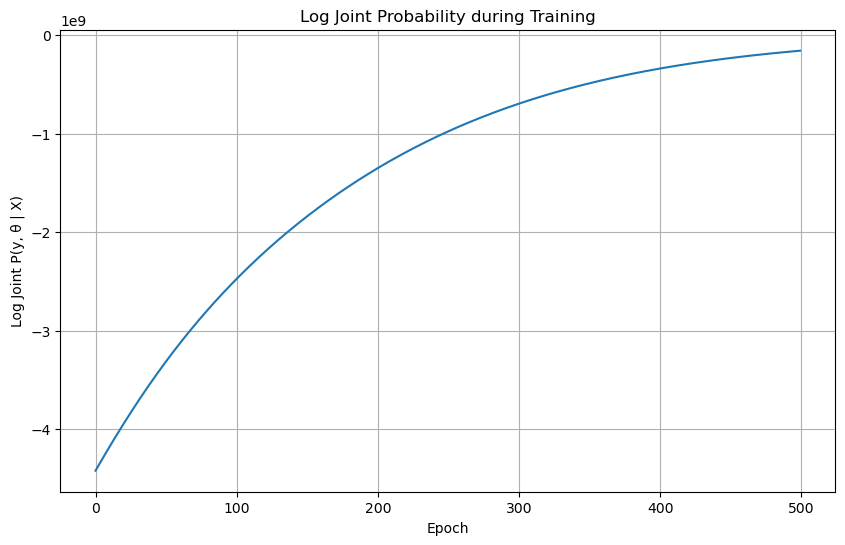

In [30]:
import torch
import torch.distributions as dist
from torch.distributions import Normal
import matplotlib.pyplot as plt
import logging



# --- Setup Logging ---
# Using a logger is good practice for research code instead of print statements.
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Model & Probability Functions ---

def log_gaussian_likelihood(x: torch.Tensor, pred_mean: torch.Tensor, sigma: float) -> torch.Tensor:
    """
    Calculates the log-likelihood using the stable torch.distributions module.
    
    Args:
        x (torch.Tensor): The observed data (ground truth).
        pred_mean (torch.Tensor): The model's predictions (the mean of the Gaussian).
        sigma (float): The standard deviation of the Gaussian.
    
    Returns:
        torch.Tensor: The total log-likelihood of the data.
    """
    # Create a tensor for sigma with the correct dtype and device
    sigma_tensor = torch.tensor(sigma, dtype=pred_mean.dtype, device=pred_mean.device)
    
    # Create a Normal distribution object. `loc` is the mean, `scale` is the standard deviation.
    normal_dist = Normal(loc=pred_mean, scale=sigma_tensor)
    
    # Calculate the log probability of the data 'x' under this distribution.
    # This is done element-wise, so we sum them to get the total log probability.
    log_prob = normal_dist.log_prob(x).sum()
    
    return log_prob

def log_gaussian_prior(theta: torch.Tensor, sigma_prior: float = 1.0) -> torch.Tensor:
    """
    Calculates the log-prior probability of the weights `theta`.
    Assumes a Gaussian prior centered at 0.
    
    Args:
        theta (torch.Tensor): The model parameters (weights).
        sigma_prior (float): The standard deviation of the Gaussian prior.

    Returns:
        torch.Tensor: The log-prior probability of the parameters.
    """
    # Using the stable distributions module is best practice.
    prior_dist = Normal(loc=0.0, scale=sigma_prior)
    return prior_dist.log_prob(theta).sum()

def main():
    """Main function to run the experiment."""
    # --- 1. Generate Synthetic Data ---
    # We will model a simple linear relationship: y = X @ theta_true + noise
    n_samples = 200
    n_features = 5
    noise_std_dev = 0.1  # True standard deviation of the noise in data generation

    # Create a "true" set of weights we want our model to discover
    theta_true = torch.tensor([2.5, -1.0, 3.3, 0.0, -4.1]).unsqueeze(1)
    
    # Generate random input data X
    X = torch.randn(n_samples, n_features)
    
    # Generate the output y using the linear model and add Gaussian noise
    noise = torch.randn(n_samples, 1) * noise_std_dev
    y = X @ theta_true + noise

    logging.info(f"Generated data with {n_samples} samples and {n_features} features.")
    logging.info(f"True theta:\n{theta_true.T}")

    # --- 2. Setup the Model and Optimizer ---
    # Initialize model parameters `theta` randomly. This is what we will learn.
    theta_model = torch.randn(n_features, 1, requires_grad=True)

    # Setup the optimizer. We use Adam, a standard choice.
    # We pass the parameter we want to optimize: `theta_model`.
    learning_rate = 0.01
    optimizer = torch.optim.Adam([theta_model], lr=learning_rate)
    
    # --- 3. Perform Gradient Ascent ---
    # We want to *maximize* the log joint. PyTorch optimizers *minimize* a loss.
    # So, our "loss" will be the *negative* log joint probability.
    epochs = 500
    log_joint_history = []
    
    logging.info("Starting gradient ascent to maximize log joint probability...")

    for epoch in range(epochs):
        # Zero out gradients from the previous iteration
        optimizer.zero_grad()
        
        # --- Forward Pass ---
        # 1. Get the model's prediction for y
        y_pred = X @ theta_model
        
        # 2. Calculate the log likelihood using the provided function
        # We pass the true noise std dev for this test.
        log_likelihood = log_gaussian_likelihood(y, y_pred, sigma=noise_std_dev)
        #log_likelihood_manual = log_gaussian_likelihood_manual(y, y_pred, sigma=noise_std_dev)
        # print the difference between the two
        #logging.info(f"Difference between the two log likelihoods: {log_likelihood - log_likelihood_manual}")
        
        # 3. Calculate the log prior on the weights
        log_prior = log_gaussian_prior(theta_model)
        
        # 4. Calculate the log joint probability (the objective we want to maximize)
        log_joint = log_likelihood + log_prior
        
        # --- Backward Pass ---
        # 5. Define the loss as the negative log joint
        loss = -log_joint
        
        # 6. Backpropagate to compute gradients
        loss.backward()
        
        # 7. Update the parameters using the optimizer
        optimizer.step()
        
        # --- Logging ---
        log_joint_history.append(log_joint.item())
        if epoch % 50 == 0:
            logging.info(f"Epoch {epoch:03d} | Log Joint: {log_joint.item():.4f} | Loss: {loss.item():.4f}")

    logging.info("Training finished.")
    logging.info(f"Learned theta:\n{theta_model.T.detach()}")
    logging.info(f"True theta:\n{theta_true.T}")
    
    # --- 4. Plot the results ---
    plt.figure(figsize=(10, 6))
    plt.plot(log_joint_history)
    plt.title("Log Joint Probability during Training")
    plt.xlabel("Epoch")
    plt.ylabel("Log Joint P(y, θ | X)")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()
